<center> <h2> DS 3000 - Fall 2020</h2> </center>
<center> <h3> DS Report </h3> </center>


<center> <h3>Classifying Presidential Rhetoric: An Analysis of Speech Sentimentality and Readability</h3> </center>
<center><h4>Eoin Daly, Constance Davis, and Mara Hubelbank</h4></center>

<hr style="height:2px; border:none; color:black; background-color:black;">

In [383]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, f_regression
from sklearn.preprocessing import KBinsDiscretizer 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

import json

#### Executive Summary:

For our final DS3000 project, we aim to analyze speech data of the 45 United States presidents. Extracting from an online corpora, we identify such features as the term frequency and importance of various social issues, as well as the overall speech linguistic complexity via applying the Flesch-Kincaid readability tests. We also extract the outcome variables of political party, speaker, and time period for each presidential speech.

After visualizing our dataset via scatterplots, pie graphs, line graphs, and word clouds, we identify several hypotheses and questions regarding our dataset. We test our hypotheses (each of which predict a correlation between a social issue feature and an outcome variable) via Pearson correlation and one-way ANOVA, and find that all of our hypotheses are supported. 

We initially construct a value-based ML model based on the DVs and IVs defined above, feeding our models strictly the numeric features extracted from the speech data. After rather disappointing results, we pivot to the construction of a linguistic ML model based on the raw textual speech data, finding the greatest accuracy using the kNN algorithm. We then hypertuned the min-df, n-grams, and stop word-usage parameters of our TfidfVectorizer. Using our model, we were able to successfully predict (>75%) the political party and time period of a given speech, and had moderate success (>60%) with predicting the speaker's identity. 

GitHub repo: https://github.com/odaily/DS3000-Project

<hr style="height:2px; border:none; color:black; background-color:black;">

## Outline
1. <a href='#1'>INTRODUCTION</a>
2. <a href='#2'>METHOD</a>
3. <a href='#3'>RESULTS</a>
4. <a href='#4'>DISCUSSION</a>

<a id="1"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 1. INTRODUCTION

**Problem Statement and Significance**

The president of the United States is tasked with a number of near-impossible roles, one of which includes setting the national, and often global, agenda for his or her time in office. One of the means through which this is accomplished is via speeches to the American public. These speeches are scrupulously crafted and edited by the president's communications staff, with the final product ideally representing an encapsulation of the given executive branch's ideology and plans for action. 

With this in mind, for our final project, we set out to analyze patterns in presidential speeches, with a goal of understanding how their sentimentality and readability have changed over time. Using online-accessible speech corpora, we chose to look into trends of progressivist rhetoric within these speeches, focusing on the usage and importance of terms related to gender issues, equality, religion, and race; moreover, we put these features in the context of political party and time period, and look for correlations and predictability between these feature and target components. Moreover, we aim to analyze changes in presidential speech complexity by applying the Flesch-Kincaid readability tests to each president's corpus. Using our final output dataset, we aim to evaluate the extent to which we can predict the political party, time period, and speaker of a given speech based on the aforementioned attributes.

**Previous Research**

There have been several prior research projects in the intersection of political speech and data science. One example is from Stanford University Machine Learning (CS229) students, who used ML models to predict the region, speaker, and year in which a speech was given. They used the logistic regression and support vector machine classification models for this task, applying topic clustering via Naive Bayes for modeling class probabilities. For the party predicition class, they report 95% accuracy of their model, and report 90% accuracy for the year prediction class using five discrete year classes. This project focused on presidential candidates, rather than in-office presidents -- we believe an interesting extension of this research could be a comparison of in-office versus running presidents' rhetoric, perhaps using a case study to see how rhetoric changes over the course of a politican's career. 

Source: Acharya, A., Crawford, N., &amp; Maduabum, M. (n.d.). *“A Nation Divided” : Classifying Presidential Speeches (Rep.)*. Retrieved http://cs229.stanford.edu/proj2016/poster/AcharyaCrawfordMaduabum-ClassifyingPresidentialSpeeches-poster.pdf


**Questions and Hypotheses**

Given the task of understanding presidential speech sentimentality and readability, we set out to tackle the following questions:
* Are there significant presidential speech sentimentality trends over time?
* Which visualization types fit best for representing the attributes and trends of our dataset?
* What machine learning algorithm (out of the ones we’ve seen used in class) can best classify the presidential speeches?
* To what degree of accuracy can we get a machine learning algorithm to predict the aforementioned target variables? (Using cross-validation procedures)
* Which feature variable will play the largest role in classification?
* Can we train a machine learning classification algorithm to classify the political party from which the speeches came? (This will utilize only speech data from after 1936, when the Democratic and Republican parties established their modern platforms.)
* How will n-gram ranges affect the accuracy of the different algorithms?

Using our final dataset, we plan to test multiple hypotheses regarding this issue. We hypothesize that:
* The frequency of female-gendered terms will increase over time.
* The frequency of male-gendered terms will decrease over time. 
* The use of religious language will decrease over time. 
* The use of equality-related rhetoric will decrease over time. 
* Religious language will be a key indicator of political party.

<a id="2"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 2. METHOD

### 2.1. Data Acquisition

Below are the sources where we obtained the original data:
* Corpus of Speeches, Presidents 1-44: http://www.thegrammarlab.com/?nor-portfolio=corpus-of-presidential-speeches-cops-and-a-clintontrump-corpus
* Corpus of Speeches, 45th President: https://millercenter.org/the-presidency/presidential-speeches 

We have multiple scripts for scraping, which are attached. Additionally, when we first created our dataset, we did some of our feature extraction, and most of our preprocessing, this script is called *InitialExtractionAndDFCreation.ipynb*; please review it, as the data we clean and extract additional features from is created by this script.

* Preprocessing/feature extraction script: https://github.com/odaily/DS3000-Project/blob/master/scripts/InitialExtractionAndDFCreation.ipynb
* Trump scraper: https://github.com/odaily/DS3000-Project/blob/master/scripts/download_trump_speeches.py

Our finite dataset has 997 rows, restricted by the number of presidential speeches; this data was acquired primarily using an online corpora, and we used web-scraping to acquire the speeches of the 45th president. We have multiple features in the dataset -- for readability, we consider such attributes as word count, sentence count, and average syllables per word, and for sentimentality, we consider the frequencies of gendered pronouns, and terms pertaining to race/religion. The target/outcome variables for our dataset include political party, president, and time period. 

Columns in our original dataset, created by *InitialExtractionAndDFCreation.ipynb*:
* word_count : the number of words in a given speech (feature)
* sentence_count : the number of sentences in a given speech (feature)
* average_words : average number of words per sentence (feature)
* average_syl_per_word : average number of syllables per word (feature)
* flesch_kincaid_score : readability score (feature)
* flesch_kincaid_grade_level : score for level of reading difficulty (feature)
* total_gendered_terms : a sum of the gendered terms in the speech (feature)
* female_gendered_terms : a sum of the female-gendered terms in the speech (feature)
* male_gendered_terms : a sum of the male-gendered terms in the speech (feature)
* terms_of_equality : a sum of the terms related to the concept of equality in the speech (feature)
* terms_for_race : a sum of the terms related race in the speech (feature)
* terms_for_religion : a sum of the terms related to religion in the speech (feature)
* political_party : indicates the political party of the speech giver (outcome)
    * 0 - independent
    * 1 - Federalist
    * 2 - Democratic-Republican
    * 3 - Whig
    * 4 - Republican pre-1865
    * 5 - Democrat pre-1865
    * 6 - National Union
    * 7 - Democrat post-1865, pre-1961
    * 8 - Republican post-1865, pre-1961
    * 9 - Democrat post-1961
    * 10 Republican post-1961
* president : indicates the president who gave the speech by name (outcome)
* time_period : indicates the political party of the speech giver (index indicating 20 year blocks since the beginning of the United States 0 - 11) (outcome)
* year (feature)

In [515]:
url = "https://raw.githubusercontent.com/odaily/DS3000-Project/master/final_proj_dataset.csv"
df = pd.read_csv(url, index_col=0)
df.head()

,speech,word_count,sentence_count,average_words,average_syl_per_word,flesch_kincaid_score,flesch_kincaid_grade_level,total_gendered_terms,female_gendered_terms,male_gendered_terms,terms_of_equality,terms_for_race,terms_for_religion,political_party,president,time_period
0,The personal inconveniences to the members of ...,3034,79,39.379747,1.708306,22.341881,19.926110,28,0,28,3,0,0,1,adams,0
1,"When it was first perceived, in early times, t...",2322,34,68.823529,1.690353,-6.024758,31.197344,14,0,14,3,1,3,1,adams,0
2,Gentlemen of the Senate and Gentlemen of the H...,2224,59,38.661017,1.681205,25.364122,19.326016,12,5,7,1,4,1,1,adams,0
3,As the safety and prosperity of nations ultima...,663,9,73.555556,1.731523,-14.310767,33.528643,5,0,5,0,0,3,1,adams,0
4,It is with peculiar satisfaction that I meet t...,1500,37,41.459459,1.730000,18.395649,20.993189,7,0,7,1,0,0,1,adams,0


### 2.2. Data Analysis

**Independent Variables**

* For numerical data, we have multiple independent variables, including: word count, sentence count, avg words, avg syllables per word, Flesch-Kincaid score (and grade level), number of gendered terms (split up as male, female, total), terms of equality, terms of race, terms of religion.

* For language data, our independent variable is the raw speech text data.

**Dependent Variables**

Our dependent variables are political party, president identity, and time period (binned in 20-year gaps).
   
**Predictive Models**

We use two types of predictive models: value-based and language-based. We feed the models either numerical data extracted from the speech parsing or the raw speech text, and aim to determine whether our models can predict political party, time period, and/or the speaker's identity. 

We have to split up our total corpus of speeches and train/test the model based off of this to make sure it's attempting the predict the correct values. Because of how our target variables are designed, this falls into a multi-classification problem.

For our numerical model, we use k-Nearest Neighbor, Gaussian Naive-Bayes and Decision Tree. For our language model, we use Gaussian and Multinomial Naive-Bayes, k-Nearest Neighbor, Decision Tree, and Logistic Regression. We also use a tfidfVectorizer for our language models, tweaking the inputs for the vectorizer to further enhance our models.

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 3. RESULTS

### 3.1. Data Wrangling

**Part 1: Data Cleaning and Wrangling**

Some of our data have incorrect or missing values for political party. Presidents should keep their same political affiliation as they had the year they first entered office; we will use data about when they entered office, find their political party for that year, and apply that to all rows for each president. Also, there are NaN values for time period for the speeches made by Donald Trump, FDR, and Ronald Reagan. This is because the years for these rows are truncated and are missing a year. The below scripts parse the year data, and clean up the aforementioned missing/truncated values.

As mentioned in section 2, we did some of our feature extraction when we created our dataset, as well as most of our preprocessing (including handling NaN values); please reference the *InitialExtractionAndDFCreation.ipynb* script as needed:

https://github.com/odaily/DS3000-Project/blob/master/scripts/InitialExtractionAndDFCreation.ipynb

In [62]:
# get the first year that the given president was in office
def getFirstYear(presName):
    return yearsAndNames[yearsAndNames['name'] == presName]['first year in office'].item()

# convert the given party name (and year, if applicable) to its corresponding unique index
def getPartyIndex(partyRaw, year):
    if partyRaw == "Independent":
        return 0
    elif partyRaw == "Federalist":
        return 1
    elif partyRaw == "Democratic-Republican" or partyRaw == "Democratic-Republican/National Republican":
        return 2
    elif partyRaw == "Whig":
        return 3
    # these Republican-Democratic chunks are used to differentiate the changing party platforms;
    # this is used by our model in predicting political party based on the speech features
    elif partyRaw == "Republican" and year < 1865:
        return 4
    elif partyRaw == "Democratic" and year < 1865:
        return 5
    elif partyRaw == "Republican/National Union" or partyRaw == "Democratic/National Union":
        return 6
    elif partyRaw == "Democratic" and year >= 1865 and year < 1961:
        return 7
    elif partyRaw == "Republican" and year >= 1865 and year < 1961:
        return 8
    elif partyRaw == "Democratic" and year >= 1961:
        return 9
    elif partyRaw == "Republican" and year >= 1961:
        return 10

In [63]:
# the data to get the year they took office
yearsUrl = "https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv"
yearsDf = pd.read_csv(yearsUrl)
yearsAndNames = pd.DataFrame(columns = ["name", "first year in office"])
yearsAndNames["first year in office"] = yearsDf['Took office '].str[-4:]
namesRaw = yearsDf["President "].str.split().str[-1].str.lower()
yearsAndNames["name"] = namesRaw

# change certain names to match our naming conventions
yearsAndNames.iloc[7] = ['vanburen', 1837]
yearsAndNames.iloc[22] = ['bharrison', 1889]
yearsAndNames.iloc[22] = ['bharrison', 1889]
yearsAndNames.iloc[22] = ['bharrison', 1889]
yearsAndNames.iloc[31] = ['fdroosevelt', 1933]
yearsAndNames.iloc[42] = ['gwbush', 2001]
yearsAndNames.iloc[5] = ['jqadams', 1825]
yearsAndNames.iloc[35] = ['lbjohnson', 1963]
yearsAndNames.loc[44]= ['trump', 2017]

parties = []
yearsAndNames['party'] = yearsDf['Party ']

# add in trump's party manually (not present in corpora)
yearsAndNames.loc[44]= ['trump', 2017, 'Republican']

# parsing party and changing it to be an index 
for name in yearsAndNames['name']:
    first_year = int(getFirstYear(name))
    party = yearsAndNames[yearsAndNames['name']==name].party.item().strip()
    parties.append(getPartyIndex(party, first_year))
    
# add the parties to the df
yearsAndNames['party'] = parties

# sets all president's political party to be the one it was when they entered office
for name in yearsAndNames['name']:
    first_year = int(getFirstYear(name))
    df.loc[df.president == name, 'political_party'] = yearsAndNames[yearsAndNames['name']==name].party.item()

# getting correct time period for trump from line 898
trump_time_period = df.iloc[898]['time_period']
# setting all of trump's data to match this
df.loc[df.president == 'trump', 'time_period'] = trump_time_period

# fixing the truncated years for two presidents
df.at[208,'year'] = 1940
df.at[814,'year'] = 1987

#checking for null values in the df
#df.isnull().sum()

---------------------------------------------------------------------------------------------------------------------------
**Part 2: Feature Extraction**

The feature extraction we will perform includes getting the weight of certain words in the corpora, using the libraries of terms defined below. We then use the TfidfVectorizer to determine the relative importance of these terms per president. Lastly, we perform target extraction via binning time periods into equal-sized chunks.

In [3]:
femaleGendered = ["she", "her", "hers", "woman", "women", "girl", "girls", "female"]
maleGendered = ["he", "him", "his", "man", "men", "boy", "boys", "male"]
equality = ["equality", "equal", "fairness", "equal rights", "equal opportunities", "egalitarian", "egalitarianism", "equity",
           "equitability"]
race = ["white", "black", "asian", "indian", "african", "caucasian", "ethnicity", "european", "hispanic", "indigenous", 
       "racism", "minority", "race", "predjudice", "racial", "latin", "latino", "latina", "jewish", "jew", "african american",
        "african-american",
       "whites", "blacks", "people of color", "native american", "native"]
religion = ["religion", "jewish", "christian", "hindu", "judaism", "hinduism", "christianity", "lutherian", "catholic", 
           "catholocism", "protestant", "protestantism", "god", "buddist", "buddism", "religous"]

In [65]:
# sum the values of the given terms in the given dictionary
def sumTermValues(terms, dictionary):
    sum = 0
    for term in terms:
        if dictionary.get(term) is not None:
            sum = sum + dictionary.get(term)
    return sum

In [66]:
# use TfidfVectorizer to determine the importance values of the given terms for the given president4
def getImportanceValue(president, terms):
    speeches = []
    
    # add each speech to the dataframe
    for speech in df[df['president'] == president]['speech']:
        speeches.append(speech.lower())
                
    # NOTE: we cannot use English stop words, because it will ignore gendered terms like he/she
    vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    vect = vectorizer.fit(speeches)
    tfidf = vectorizer.fit_transform(speeches)
    values = tfidf.toarray().tolist()
    flatList = []
    for elem in values:
        flatList.extend(elem)
    keys = vectorizer.get_feature_names()
    dictionary = {} 
    for key in keys: 
        for value in flatList: 
            dictionary[key] = value 
            flatList.remove(value) 
            break 
    return sumTermValues(terms, dictionary)

In [67]:
# determine the importance value of the given terms in the given row
def label_president(row, terms):
    return getImportanceValue(row['president'], terms)

In [69]:
df['importance_of_equality'] = df.apply (lambda row: label_president(row, equality), axis=1)
df['importance_of_race'] = df.apply (lambda row: label_president(row, race), axis=1)
df['importance_of_religion'] = df.apply (lambda row: label_president(row, religion), axis=1)
df['importance_of_female_gendered_terms'] = df.apply (lambda row: label_president(row, femaleGendered), axis=1)
df['importance_of_male_gendered_terms'] = df.apply (lambda row: label_president(row, maleGendered), axis=1)

In [ ]:
# 1. create bins of 61-year periods of time and append this to the dataframe
discretizer = KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'quantile')
time_period_discretized = discretizer.fit_transform(df['time_period'].values.reshape(-1, 1))
time_period_df = pd.DataFrame(time_period_discretized, columns = ['timePeriod60YearBin'])
df = pd.concat([df, time_period_df], axis=1, sort=False)

# 2. create bins of 122-year periods of time and append this to the dataframe
discretizer = KBinsDiscretizer(n_bins = 2, encode = 'ordinal', strategy = 'quantile')
time_period_discretized2 = discretizer.fit_transform(df['time_period'].values.reshape(-1, 1))
time_period_df2 = pd.DataFrame(time_period_discretized2, columns = ['timePeriod100YearBin'])
df = pd.concat([df, time_period_df2], axis=1, sort=False)

---------------------------------------------------------------------------------------------------------------------------
**Part 3: Feature Selection**

In this section, we conduct feature selection using model-based, RFE, and univariate selection transformers. We then test its effect on the data using a Linear Regression model. We conclude that, since feature selection only decreases our model's accuracy, we will decline to feature select in our final model.

In [139]:
y = df ['political_party']
X = df.drop(columns=['timePeriod60YearBin', 'timePeriod100YearBin', 'political_party', 'time_period', 'president', 'speech'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=300)

dict = {'model based selection: ': SelectFromModel(estimator=DecisionTreeRegressor(random_state = 3000), threshold = 'median'),
       'RFE: ' : RFE(DecisionTreeRegressor(random_state = 3000), n_features_to_select = 10), 
       'Univariate: ': SelectKBest(score_func = f_regression, k = 10)}

for selector in dict:
    # fitting the selector
    select = dict.get(selector)
    select.fit(X_train, y_train)
    X_train_selected = select.transform(X_train)
    X_test_selected = select.transform(X_test)

    #testing the selector results
    model = LinearRegression().fit(X=X_train, y=y_train)
    print('original results: ')
    print('r2_score for training set: ', r2_score(y_train, model.predict(X_train)))
    print('r2_score for testing set: ', r2_score(y_test, model.predict(X_test)))

    model = LinearRegression().fit(X=X_train_selected, y=y_train)
    print()
    print('With selected features from  ', selector)
    print('r2_score for training set: ', r2_score(y_train, model.predict(X_train_selected)))
    print('r2_score for testing set: ', r2_score(y_test, model.predict(X_test)))

original results: 
r2_score for training set:  0.8932183414736633
r2_score for testing set:  0.9101737557399923

With selected features from model based selection: 
r2_score for training set:  0.8932183414736633
r2_score for testing set:  0.9101737557399923

original results: 
r2_score for training set:  0.8932183414736633
r2_score for testing set:  0.9101737557399923

With Selected Feature from RFE: 
r2_score for training set:  0.8809131133074091
r2_score for testing set:  0.8983732597246381

original results: 
r2_score for training set:  0.8932183414736633
r2_score for testing set:  0.9101737557399923

With Selected Features from Univariate: 
r2_score for training set:  0.8681246203657097
r2_score for testing set:  0.8832530491617652


In [48]:
df.to_csv(r'final_proj_dataset_with_importance.csv')

**Note:** Our final outpt dataset is accessible here:

https://raw.githubusercontent.com/odaily/DS3000-Project/master/final_proj_dataset_with_importance.csv

### 3.2. Data Exploration

We drop the speech data and just look at our numerical features for our data exploration. We look first at the Flesch-Kincaid readability scores, then to the term frequencies and importance to visualize trends of progressivism in presidential speeches over time.

In [22]:
url = "https://raw.githubusercontent.com/odaily/DS3000-Project/master/final_proj_dataset_with_importance.csv"
df_viz = pd.read_csv(url, index_col=0)

df_viz = df_viz.drop(columns=['speech']).sort_values(by=['year'])

df_viz.head()

,word_count,sentence_count,average_words,average_syl_per_word,flesch_kincaid_score,flesch_kincaid_grade_level,total_gendered_terms,female_gendered_terms,male_gendered_terms,terms_of_equality,...,terms_for_religion,political_party,president,time_period,year,importance_of_equality,importance_of_race,importance_of_religion,importance_of_female_gendered_terms,importance_of_male_gendered_terms
944,1436,1,56.038462,1.704735,5.735349,26.380877,9,1,8,1,...,0,0.0,washington,0.0,1789,0.011076,0.015452,0.0,0.015452,0.067105
948,439,1,73.333333,1.601367,-3.073960,31.906128,9,0,9,0,...,1,0.0,washington,0.0,1789,0.011076,0.015452,0.0,0.015452,0.067105
947,854,1,39.181818,1.754098,18.668733,20.389270,0,0,0,0,...,0,0.0,washington,0.0,1790,0.011076,0.015452,0.0,0.015452,0.067105
946,1413,1,28.115385,1.510262,50.529732,13.196090,11,0,11,0,...,0,0.0,washington,0.0,1790,0.011076,0.015452,0.0,0.015452,0.067105
945,1408,1,35.268293,1.648438,31.579870,17.616197,2,0,2,0,...,1,0.0,washington,0.0,1790,0.011076,0.015452,0.0,0.015452,0.067105


----------------------------
**Part 1: Readability Vizualizations**

Note: Grover Cleveland is the 22nd and 24th president, but these visualizations are person-wise, hence n=44.

In [508]:
# First, we'll do some more manipulations of the Flesch-Kincaid Reading Ease Scores.
'''
We reference the following scale to categorize the continuous flesch_kincaid_score column:
90-100 : Very Easy
80-89 : Easy
70-79 : Fairly Easy
60-69 : Standard
50-59 : Fairly Difficult
30-49 : Difficult
0-29 : Very Confusing
Source:  https://bit.ly/343iUhf
'''

def level(score):
    if score >= 90:
        return "very easy"
    elif score >= 80:
        return "easy"
    elif score >= 70:
        return "fairly easy"
    elif score >= 60:
        return "standard"
    elif score >= 50:
        return "fairly difficult"
    elif score>= 30:
        return "difficult"
    else:
        return "very confusing"
    
df_viz_c = df_viz[['president', 'flesch_kincaid_score', 'year', 'political_party']].copy().reset_index().drop(columns='index')

df_read = pd.DataFrame()
df_read['avg_score'] = df_viz_c.groupby('president')['flesch_kincaid_score'].mean()
df_read['avg_level'] = df_read['avg_score'].map(level)
df_read['std_score'] = df_viz_c.groupby('president')['flesch_kincaid_score'].std()

df_read = df_read.merge(df_viz_c, how='left', on='president')
df_read = df_read.sort_values(by='year').drop_duplicates(subset='president').set_index('president').drop(columns=['flesch_kincaid_score'])

df_read.head(10)

,avg_score,avg_level,std_score,year,political_party
president,,,,,
washington,1.200585,very confusing,52.367549,1789,0.0
adams,17.416300,very confusing,19.210278,1797,1.0
jefferson,30.783857,difficult,20.463854,1801,2.0
madison,10.211255,very confusing,14.880687,1809,2.0
monroe,32.668519,difficult,3.200842,1817,2.0
jqadams,24.556304,very confusing,12.182749,1821,2.0
jackson,17.622098,very confusing,18.362858,1829,5.0
vanburen,17.880366,very confusing,11.681500,1837,5.0
tyler,24.492629,very confusing,9.023631,1841,3.0


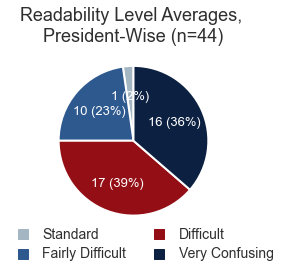

In [299]:
# 1. Readability Level Averages, President-Wise (PIE)

COLORS = ['#a4b6c1', '#2e598f', '#940f15', '#0c2141']
TEXT_COLOR = '#ffffff' #'#ebead9'
LABEL_TEXT_COLOR = '#2f2f2f'

df_read_pie = pd.DataFrame()
df_read_pie = df_read.groupby('avg_level').count().drop(columns=['std_score', 'year', 'political_party']).rename(columns = {'avg_score':'count'}) 
sort_lev = ['standard', 'fairly difficult', 'difficult', 'very confusing']
df_read_pie = df_read_pie.reindex(sort_lev)

def format_label(pct, data):
    absolute = int(round(pct/100.*np.sum(data)))
    return str(absolute) + " (" + str(int(round(pct))) + "%)"

ax = plt.gca()
texts = ax.pie(df_read_pie['count'], autopct=lambda pct: format_label(pct, df_read_pie['count']), colors=COLORS, startangle=90, wedgeprops=dict(linewidth=2, edgecolor='w'))
plt.rcParams['font.size'] = 13
plt.rcParams['text.color'] = TEXT_COLOR

# Make the title
ax.set_title("Readability Level Averages, \nPresident-Wise (n=" + str(sum(df_read_pie['count'])) + ")", fontsize=18, color=LABEL_TEXT_COLOR)

# Make the legend
custom_lines = [Line2D([0], [0], color=c, marker="s", markersize=10, linewidth=0, label=lab.title()) for c, lab in zip(COLORS, df_read_pie.index)]
leg = plt.legend(handles=custom_lines, loc="center", ncol=2, framealpha=0, bbox_to_anchor=(0.55, -0.05))
for text in leg.get_texts():
    plt.setp(text, color = LABEL_TEXT_COLOR, fontsize=14)
    
plt.tight_layout()
plt.savefig('readability-pie.png')

**Description/Interpretation:** The above pie graph represents the distribution of the average readability levels of each president. We can see that there are three values not represented -- namely, the Very Easy, Easy, and Fairly Easy levels; moreover, there is only one president whose average readability level falls into Standard, President Trump. We can see that an overwhelming majority (75%) of presidential speeches fall into the Difficult and Very Confusing categories. According to the Flesch-Kincaid formula breakdown, the shorter the sentences and words contained within a text, the easier it is to read. From this definition coupled with this visualization, we can hypothesize that presidential speeches tend to be more complicated than the average English speaker's sentences.

**Variables considered:** Flesch-Kincaid readability scores (averaged, converted to levels defined above)

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/readability-pie.png

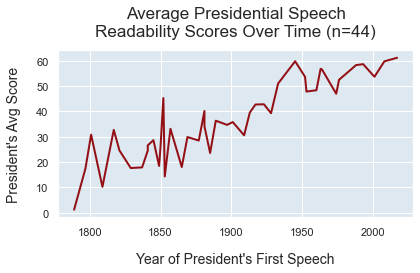

In [297]:
# 2. Average Presidential Speech Readability Scores Over Time (LINE)

TEXT_COLOR = '#2f2f2f'
sns.set(rc={'axes.facecolor':'#dde8f0'})

df_read.set_index('year')['avg_score'].plot(linewidth=2, color='#940f15')

plt.xlabel("Year of President's First Speech", labelpad=15, fontsize=14)
plt.ylabel("President's Avg Score", labelpad=15, fontsize=14)
plt.title("Average Presidential Speech\nReadability Scores Over Time (n=" + str(len(df_read.index)) + ")", 
          y=1.05, fontsize=17)

plt.tight_layout()
plt.savefig('readability-line.png')

**Description/Interpretation:** Looking at the above graph, we can see that there is an obvious upward trend in average presidential readability scores over time. While this may suggest that presidents' language has been "dumbed-down" over time, we suspect that it might also point to the modernity of the readability tests over anything else. The Flesch-Kincaid readablity test used here favors short words and short sentences, while the founding fathers generally did not -- it might be interesting to look into normalizing the Flesch-Kincaid readability scores of a given president based on the average readability score of the United States populus during his time in office. Moreover, we think it could be interesting to track readability on a case study level, tracking the readability of one president from the time he announces his campaign to the end of his time in office, or to compare the readability scores of a group of presidential candidates.

**Variables considered:** Flesch-Kincaid readability scores (averaged), year of each president's first recorded speech

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/readability-line.png

----------------------------
**Part 2: Sentimentality Vizualizations**

First, we generated a word cloud based on the term frequencies throughout the speeches, ignoring English stop words. We then experimented with scatterplot visualizations of the usage/importance of the features, and left in those which are relevant to our hypotheses.

In [389]:
# 3. Overall Term Frequencies (WORD CLOUD -- NEW VISUALIZATION TYPE)

text = ''
for i, row in df.iterrows():
    text += str(row['speech']) + ' '

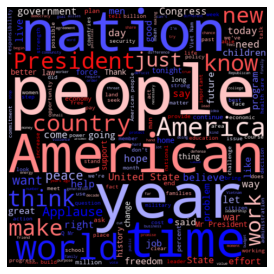

In [513]:
wordcloud = WordCloud(width=480, height=480, colormap="bwr", stopwords=ENGLISH_STOP_WORDS).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('pres-cloud.png')

**Description/Interpretation:** The above word cloud demonstrates the most frequently occurring terms in US Presidential speeches, excluding the English stop words provided by sklearn. From this visualization, we can see the overarching themes throughout presidential rhetoric.

**Variables considered:** Frequency of all speech terms

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/pres-cloud.png

Out of curiosity, we also decided to visualize the post-1961 Democratic and Republican parties' word clouds:

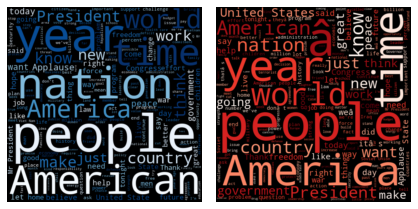

In [509]:
# Democratic and Republican Party Clouds

# Split into post-1961 democratic and republican parties
text_d = ''
text_r = ''
for i, row in df.iterrows():
    if row['political_party'] == 9.0:
        text_d += str(row['speech']) + ' '
    elif row['political_party'] == 10.0:
        text_r += str(row['speech']) + ' '

fig, (ax1, ax2) = plt.subplots(1, 2)        
wordcloud_d = WordCloud(width=480, height=480, colormap="Blues", stopwords=ENGLISH_STOP_WORDS).generate(text_d)
ax1.imshow(wordcloud_d, interpolation="bilinear")
ax1.axis("off")
ax1.margins(x=0, y=0)

wordcloud_r = WordCloud(width=480, height=480, colormap="Reds", stopwords=ENGLISH_STOP_WORDS).generate(text_r)
ax2.imshow(wordcloud_r, interpolation="bilinear")
ax2.axis("off")
ax2.margins(x=0, y=0)

fig.tight_layout()
plt.savefig('dem-rep-cloud.png')

**Description/Interpretation:** As we can see, the major themes between post-1961 Democratic and Republican presidential speeches are largely comparable. "Nation" does seem to hold much more importance in Democratic speeches than in Republican speeches, but we would need to do a term-by-term comparison to see broader thematic discrepancies. It would be interesting to compare the themes between one party's presidents and its presidential candidates, to try to evaluate the major differences of the agenda of a candidate versus an in-office president.

**Variables considered:** Frequency of all speech terms

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/dem-rep-cloud.png

In [514]:
# 4. Correlations (SCATTERPLOTS)

# generate a scatterplot visualization of the given column, indicate whether it is raw or importance term data
# average year of president's speeches goes on y-axis
def scatter(col_raw, col_imp):
    title_l = col_raw.split('_')
    title = ''
    for word in title_l:
        if (word.lower() != 'of' and word.lower() != 'terms' and word.lower() != 'for'):
            title += word.title() + ' '
    
    fig, (ax1, ax2) = plt.subplots(1, 2)      

    df_avg_raw = df_viz.sort_values(by="year").groupby('president')[[col_raw, "year"]].mean()
    ax1.scatter(x=df_avg_raw["year"], y=df_avg_raw[col_raw])
    ax1.set(xlabel='Average Speech Year', ylabel='Frequency of ' + title + 'Terms')
    
    df_avg_imp = df_viz.sort_values(by="year").groupby('president')[[col_imp, "year"]].mean()
    ax2.scatter(x=df_avg_imp["year"], y=df_avg_imp[col_imp])
    ax2.set(xlabel='Average Speech Year', ylabel='Importance of ' + title + 'Terms')
    
    fig.suptitle('Frequency and Importance of ' + title + 'Terms', fontsize=16, color='black', y=1.05)
    fig.tight_layout()
    plt.savefig(col_raw + '_scatter.png', bbox_inches = "tight")

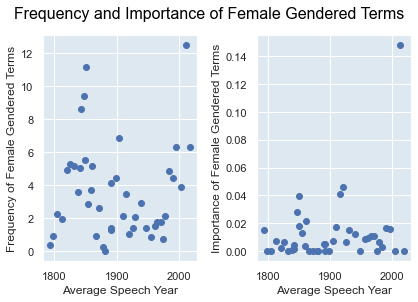

In [502]:
# Usage of Female-Gendered Terms
scatter('female_gendered_terms', 'importance_of_female_gendered_terms')

**Description/Interpretation:** Looking at the above graphs, we cannot identify an obvious correlation between the average speech year and the frequency or importance of female-gendered terms.

**Variables considered:** Speech year (averaged), frequency of female-gendered terms (left, averaged), importance of female-gendered terms (right, averaged)

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/female_gendered_terms_scatter.png

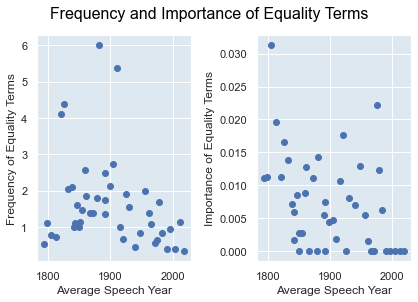

In [503]:
# Usage of Equality-Related Terms
scatter('terms_of_equality', 'importance_of_equality')

**Description/Interpretation:** Looking at the above graphs, we can see that there is a potentially small negative correlation between the frequency of equality-related terms and the year of the speeches, suggesting that the importance of terms related to equality has decreased in the presidential speech agenda over time.

**Variables considered:** Speech year (averaged), frequency of equality-related terms (left, averaged), importance of equality-related terms (right, averaged)

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/terms_of_equality_scatter.png

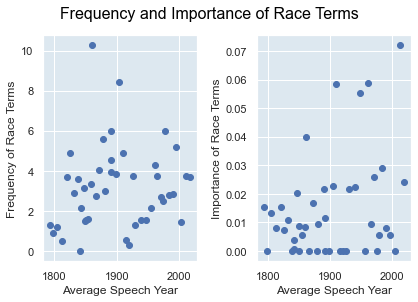

In [504]:
# Usage of Race-Related Terms
scatter('terms_for_race', 'importance_of_race')

**Description/Interpretation:** Looking at the above graphs, we cannot identify an obvious correlation between the average speech year and the frequency of race-related terms; there is perhaps a slight positive correlation with the importance of race-related terms.

**Variables considered:** Speech year (averaged), frequency of race-related terms (left, averaged), importance of race-related terms (right, averaged)

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/terms_for_race_scatter.png

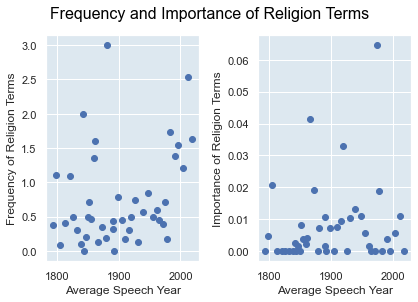

In [505]:
# Usage of Religious Terms
scatter('terms_for_religion', 'importance_of_religion')

**Description/Interpretation:** Looking at the above graphs, we can see a slight increase in the usage of religious terms over time, but not much of an increase in importance of religious terms.

**Variables considered:** Speech year (averaged), frequency of religion-related terms (left, averaged), importance of religion-related terms (right, averaged)

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/terms_for_religion_scatter.png

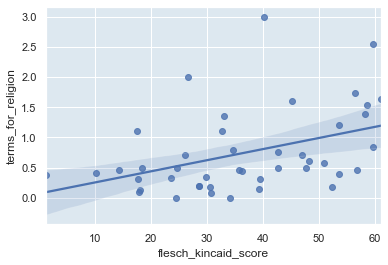

In [506]:
# Inter-feature correlation. We performed a few of these; the below code is one example. 

df_avg = df_viz.sort_values(by="year").groupby('president')[['terms_for_religion', 'flesch_kincaid_score']].mean()
ax = sns.regplot(x=df_avg["flesch_kincaid_score"], y=df_avg['terms_for_religion'], fit_reg=True)

**Description/Interpretation:** Looking at the above graph, we can see a slight positive correlation between the average number of terms for religion used and the average Flesch-Kincaid score for each president. This is interesting, because it suggests that presidents who use religious language may choose to simplify their sentence structure for their speechs.

**Variables considered:** Frequency of religion-related terms (averaged), Flesch-Kincaid readability score (averaged)

**GitHub link:** https://github.com/odaily/DS3000-Project/blob/master/visualizations/religion_readability_scatter.png

### 3.3. Model Construction

**Part 1: Hypothesis Testing**

We will perform both Pearson Correlation tests because we have the continuous independent variable of time (in years), and in addition we will perform a one-way ANOVA test for our fifth hypothesis which has a discretized independent variable. These will be used to test all five of our hypotheses. 

**Hypothesis 1** 
 * Frequency of female gendered terms will increase over time in presidential speeches
 * Null Hypothesis - there is no correlation between time and the frequency of female gendered terms in presidential speeches 
     * Null Hypothesis would yield a value of 0 for pearson correlation 
     
We will first perform a Pearson Correlation Test comparing Time to
number of female gendered terms, and also importance of female gendered terms. For the pearson test we will use this scale: 
https://www.statisticssolutions.com/pearsons-correlation-coefficient/#:~:text=High%20degree%3A%20If%20the%20coefficient,to%20be%20a%20small%20correlation 
to interpret our results.

We will also be using the calculated importance of female gendered terms based on tfdif scores, instead of the raw frequency as we believe this to be more descriptive.

In [ ]:
#finding standard error of number of female gendered terms
stderr = stats.sem(df['female_gendered_terms'])
# finding the correlation between time and number of female gendered terms
IV = df['year']
DV = df['female_gendered_terms']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
teststat = (corr - 0)/stderr
teststat

Since our test statistic is less than one, it seems our null hypothesis must be accepted that there is no correlation between the time and the frequency of female gendered terms. However we believe that importance of female gendered terms in speeches based on tfidf scores is more indicative of social change, so will run this test as well in support of our original hypothesis. 

In [ ]:
#finding standard error of importance of female gendered terms
stderr = stats.sem(df['importance_of_female_gendered_terms'])
# finding the correlation between time and importance of female gendered terms
IV = df['year']
DV = df['importance_of_female_gendered_terms']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
teststat = (corr - 0)/stderr
teststat

Since the correlation between importance of female gendered terms and time is positive, and our test statistic is much larger than one, we have found that we can reject the null hypothesis that there is no correlation between the importance of female gendered terms and time.

**Hypothesis 2** 
 * Frequency of male gendered terms will decrease over time in presidential speeches
 * Null Hypothesis - there is no correlation between time and the frequency of male gendered terms in presidential speeches 
     * Null Hypothesis would yield a value of 0 for pearson correlation
     
We will first perform a Pearson Correlation Test comparing Time to
number of male gendered terms, and also importance of male gendered terms. 

In [ ]:
#finding standard error of female gendered terms
stderr = stats.sem(df['male_gendered_terms'])
# finding the correlation between time and female gendered terms
IV = df['year']
DV = df['male_gendered_terms']
corr, _ = pearsonr(IV, DV)
print('correlation value: ', corr)
teststat = (corr - 0)/stderr
teststat

Though we have found a low degree of positive correlation between male gendered terms and time, our test statistic is less than one. Thus we accept the null hypothesis which states that there is no correlation between time and the frequency of male gendered terms in presidential speeches. But once again we will check the importance of male gendered terms to support our original hypothesis, since we see importance values as more descriptive of social change.

In [ ]:
#finding standard error of importance of male gendered terms
stderr = stats.sem(df['importance_of_male_gendered_terms'])
# finding the correlation between time and importance of male gendered terms
IV = df['year']
DV = df['importance_of_male_gendered_terms']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
# making the correlation positive for test statistic calculations
corr = -corr
teststat = (corr - 0)/stderr
teststat

Since the correlation between importance of male gendered terms and time is negative, and our test statistic is much larger than one, we have found that we can reject the null hypothesis that there is no correlation between the importance of male gendered terms and time.

**Hypothesis 3** 
 * The use of religious language will decrease over time in presidential speeches.
 * Null Hypothesis - there is no correlation between time and the frequency or importance of religious language in presidential speeches 
     * Null Hypothesis would yield a value of 0 for pearson correlation
     
We will first perform a Pearson Correlation Test comparing Time to
number of religious terms, and also importance of religious terms. 

In [ ]:
#finding standard error of number of religious terms
stderr = stats.sem(df['terms_for_religion'])
# finding the correlation between time and number of religious terms
IV = df['year']
DV = df['terms_for_religion']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
teststat = (corr - 0)/stderr
teststat

Our correlation value between time and frequency of religious terms is positive, meaning our original hypothesis is incorrect, however based on our test statistic, we can see that the null hypothesis can be rejected, and there is a correlation between religious terms and time, we will explore further by performing a pearson correlation test on the importance of religious terms.

In [ ]:
#finding standard error of importance of religious terms
stderr = stats.sem(df['importance_of_religion'])
# finding the correlation between time and importance of religious terms
IV = df['year']
DV = df['importance_of_religion']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
# making the correlation positive for test statistic calculations
corr = -corr
teststat = (corr - 0)/stderr
teststat

Here we find a negative correlation between the importance of religious terms and time, which would support our original hypothesis. And we find a test statistic which is much greater than 1, meaning we can reject the null hypothesis once again and we have support of our original hypothesis. 

**Hypothesis 4** 
 * The use of equality based rhetoric will decrease over time in presidential speeches.
 * Null Hypothesis - there is no correlation between time and the frequency or importance of equality based rhetoric in presidential speeches 
     * Null Hypothesis would yield a value of 0 for pearson correlation
     
We will first perform a Pearson Correlation Test comparing Time to
number of terms relating to equality, and also importance of terms relating to equality. 

In [ ]:
#finding standard error of number of terms relating to equality
stderr = stats.sem(df['terms_of_equality'])
# finding the correlation between time and number of terms relating to equality
IV = df['year']
DV = df['terms_of_equality']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
# making the correlation positive for test statistic calculations
corr = -corr
teststat = (corr - 0)/stderr
teststat

Since we find a negative correlation between time and the number of terms relating to equality, and we find a test statistic greater than 1, we can reject the null hypothesis and accept our own hypothesis. We will also do a Pearson correlation test on the importance of these terms.

In [ ]:
#finding standard error of importance of terms relating to equality
stderr = stats.sem(df['importance_of_equality'])
# finding the correlation between time and importance of terms relating to equality
IV = df['year']
DV = df['importance_of_equality']
corr, _ = pearsonr(IV, DV)
print('correlation value:', corr)
# making the correlation positive for test statistic calculations
corr = -corr
teststat = (corr - 0)/stderr
teststat

Since we again find a negative correlation between the importance of terms relating to equality and time, and we have a test statistic that is much larger than 1, we can reject the null hypothesis and accept our own. 

**Hypothesis 5** 
 * Religious language will differ greatly over political parties.
 * Null Hypothesis - there is no correlation between political party and religious language in presidential speeches 
     * Null Hypothesis would yield a p-value of < 0.05 for one-way ANOVA 
     
 We will conduct a one-way ANOVA test across the modern Democratic and Republican political parties, to test if our hypothesis about a signifcant difference in their use of religious language is correct. 

In [ ]:
# getting descriptives
descriptives = df.groupby('political_party').agg(['count', 'mean', 'std', 'sem'])['terms_for_religion']
descriptives

In [ ]:
# political party groups 
Democrat_post_1961 = df[df['political_party']==9.0]['terms_for_religion']
Republican_post_1961 = df[df['political_party']==10.0]['terms_for_religion']

results = stats.f_oneway(
              Democrat_post_1961, Republican_post_1961)
# getting our fstatistic
fstatistic = results[0]
print('fstat: ', fstatistic)
# getting our p-value
pvalue = results[1]
print('pvalue: ', format(pvalue, '.10f'))

# getting degrees freedom
df1 = len(descriptives) - 1
df2 = (len(Independent) - 1) + (len(Federalist) - 1) + (len(Democratic_Republican) - 1) + (len(Whig) - 1) +(len(Republican_pre_1865) - 1) + (len(Democrat_pre_1865) - 1) + (len(National_Union) - 1) + (len(Democrat_post_1865_pre_1961) - 1) + (len(Republican_post_1865_pre_1961) - 1) + (len(Democrat_post_1961) - 1) + (len(Republican_post_1961) - 1)
print('degrees of freedom: ', df1, ', ', df2)

Since our one-way ANOVA test yielded an fstatistic greater than 1, and a p-value greater than 0.05, we can reject the null hypothesis and accept our own, that religious language does differ greatly across political parties.

In [ ]:
# assumption checks for one-way ANOVA

# checking the assumption of equality of variance
levene_results = stats.levene(
              Democrat_post_1961, Republican_post_1961)
print(levene_results)
# checking the assumption of normality
demShapiro = stats.shapiro(Democrat_post_1961)
repShapiro = stats.shapiro(Republican_post_1961)
print(demShapiro)
print(repShapiro)

Our levene result's pvalue is greater than 0.05, however our pvalues for our shapiro tests are less than 0.05. Since the one-way ANOVA test is robust enough to handle violations of the assumption of normality, we will still accept the results of this test.

---
**Part 2: Model Construction**

We have two model types: value-based (using the numerical features) and language-based (using the speech column to conduct sentiment analysis).

In [ ]:
df = pd.read_csv("../final_proj_dataset.csv")
df = df.drop(['Unnamed: 0', 'speech'], axis=1)
features = df.drop(['political_party','president','time_period'], axis=1)
target_party = df['political_party']
target_pres = df['president']
target_period = df['time_period']

# Manual changing of pres names to ints
keyVals = json.load(open('model/presidentKeys.json'))
target_pres = target_pres.apply(lambda x: list(keyVals.keys())[list(keyVals.values()).index(x)])

In [ ]:
estimators_num = {
    'k-Nearest Neighbor': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}
estimators_lang = {
    "Gaussian Naive Bayes": GaussianNB(),
    "MultinomialNB": MultinomialNB(alpha = 0.5),
    "k-Nearest Neighbor": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression()
}
vectorizers = {
    "Count Vectorizer": CountVectorizer(),
    "TFIDF Vectorizer": TfidfVectorizer(),
    "TFIDF Vectorizer w/ min_df=2": TfidfVectorizer(min_df=2),
    "TFIDF Vectorizer w/ min_df=5": TfidfVectorizer(min_df=5),
    "TFIDF Vectorizer w/ min_df=2, StopWords": TfidfVectorizer(min_df=2, stop_words="english"),
    "TFIDF Vectorizer w/ min_df=5, StopWords": TfidfVectorizer(min_df=5, stop_words="english"),
    "TFIDF Vectorizer w/ ngrams=(1,2), min_df=2": TfidfVectorizer(min_df=2, ngram_range=(1,2)),
    "TFIDF Vectorizer w/ ngrams=(1,3), min_df=2": TfidfVectorizer(min_df=2, ngram_range=(1,2)),
    "TFIDF Vectorizer w/ ngrams=(1,2), min_df=5": TfidfVectorizer(min_df=5, ngram_range=(1,2)),
    "TFIDF Vectorizer w/ ngrams=(1,3), min_df=5": TfidfVectorizer(min_df=5, ngram_range=(1,2)),
    "TFIDF Vectorizer w/ ngrams=(1,2), min_df=2, StopWords": TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words="english"),
    "TFIDF Vectorizer w/ ngrams=(1,3), min_df=2, StopWords": TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words="english"),
    "TFIDF Vectorizer w/ ngrams=(1,2), min_df=5, StopWords": TfidfVectorizer(min_df=5, ngram_range=(1,2), stop_words="english"),
    "TFIDF Vectorizer w/ ngrams=(1,3), min_df=5, StopWords": TfidfVectorizer(min_df=5, ngram_range=(1,2), stop_words="english"),
}
all_targets = {
    'Political Party':target_party, 
    'President':target_pres, 
    'Time Period':target_period
}

### 3.4. Model Evaluation

For the linear regression models, we looked at r^2 values of the models. In our numerical models, we were able to use KFolds to get us the mean and standard deviations of the testing accuracy for the models. Due to time and resource constraints given the massive corpora sizes, we chose to evaluate each language model's performance largely on its training and testing accuracy. 

Initially, a lot of our language models were subject to overfitting; this overfitting occured in almost every model at least once with the inital vectorizer settings. Through fine tuning of the vectorizer, we were able to reduce the overfitting effect on our model.

In [6]:
for target_name, target in all_targets.items():
    print(f"{target_name} models:")
    
    for estimator_name, estimator in estimators_num.items():
        kfold = KFold(n_splits=10, shuffle=True, random_state=820)
        scores = cross_val_score(estimator=estimator, X=features, y=target, cv=kfold)
        print(f"{estimator_name}:\n\tMean accuracy: {scores.mean():.2%}, std: {scores.std():.2%}")
        
    print('\n')
    
print("Done!")     

Political Party models:
k-Nearest Neighbor:
	Mean accuracy: 28.08%, std: 4.48%
Gaussian Naive Bayes:
	Mean accuracy: 30.29%, std: 3.73%
Decision Tree:
	Mean accuracy: 37.52%, std: 3.86%


President models:
k-Nearest Neighbor:
	Mean accuracy: 9.33%, std: 2.19%
Gaussian Naive Bayes:
	Mean accuracy: 17.54%, std: 4.48%
Decision Tree:
	Mean accuracy: 18.25%, std: 3.57%


Time Period models:
k-Nearest Neighbor:
	Mean accuracy: 21.36%, std: 1.83%
Gaussian Naive Bayes:
	Mean accuracy: 23.96%, std: 3.50%
Decision Tree:
	Mean accuracy: 31.39%, std: 4.88%


Done!


In [4]:
for target_name, target in all_targets.items():
    print(f"{target_name} models:")
    
    for vect_name, vectorizer in vectorizers.items():
        print(f"\tUsing {vect_name} as vect:")
        
        for estimator_name, estimator in estimators_lang.items():
            X_train, X_test, y_train, y_test = train_test_split(text, target)
            
            vect = vectorizer.fit(X_train)
            
            X_train_vect = vect.transform(X_train).toarray()
            X_test_vect = vect.transform(X_test).toarray()
            
            estimator.fit(X=X_train_vect, y=y_train)
            
            print(f"\t\t{estimator_name}:")
            print(f"\t\t\tTrain acc: {estimator.score(X_train_vect, y_train)}")
            print(f"\t\t\tTest  acc: {estimator.score(X_test_vect, y_test)}")

Political Party models:
	Using Count Vectorizer as vect:
		Gaussian Naive Bayes:
			Train acc: 0.9852744310575636
			Test  acc: 0.624
		MultinomialNB:
			Train acc: 0.8808567603748326
			Test  acc: 0.68
		k-Nearest Neighbor:
			Train acc: 0.6305220883534136
			Test  acc: 0.472
		Decision Tree:
			Train acc: 1.0
			Test  acc: 0.504
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
		Logistic Regression:
			Train acc: 0.9892904953145917
			Test  acc: 0.716
	Using TFIDF Vectorizer as vect:
		Gaussian Naive Bayes:
			Train acc: 1.0
			Test  acc: 0.644
		MultinomialNB:
			Train acc: 0.3453815261044177
			Test  acc: 0.32
		k-Nearest Neighbor:
			Train acc: 0.6546184738955824
			Test  acc: 0.584
		Decision Tree:
			Train acc: 1.0
			Test  acc: 0.46
		Logistic Regression:
			Train acc: 0.6720214190093708
			Test  acc: 0.52
	Using TFIDF Vectorizer w/ min_df=2 as vect:
		Gaussian Naive Bayes:
			Train acc: 1.0
			Test  acc: 0.56
		MultinomialNB:
			Train acc: 0.4685408299866131
			Test  acc: 0.352
		

The numerical models seem to be very weak; however, the bag-of-words and n-gram models seem to be generally overfitting throughout. This issue is fixed with finer tuning of the tfidfVectorizer below.

### 3.5. Model Optimization

Below, we conduct model optimization with different fields in the tfidfVectorizer using kNN, since kNN tended to result in more models with >=70% test accuracy. Lots of the language models were overfitted, but fine-tuning tfidf helps with that. 

In [2]:
# Iterating through configs of the tfidfVectorizer
min_df_ops = [2,3,4,5]
stop_words_ops = [None, "english"]
ngram_range_ops = [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)]

for target_name, target in all_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(text, target)
    print(f"\n{target_name}")
    
    for m_df in min_df_ops:
        for stops in stop_words_ops:
            for ngrams in ngram_range_ops:
                vect = TfidfVectorizer(min_df=m_df, ngram_range=ngrams, stop_words=stops)
                vect = vect.fit(X_train)

                estimator = KNeighborsClassifier()

                X_train_vect = vect.transform(X_train).toarray()
                X_test_vect = vect.transform(X_test).toarray()

                estimator.fit(X=X_train_vect, y=y_train)
                print(f"df={df}, stops={stops}, ngram_range={ngrams}")
                print(f"train={estimator.score(X_train_vect, y_train)}")
                print(f"testt={estimator.score(X_test_vect, y_test)}")


Political Party
df=2, stops=None, ngram_range=(1, 1)
train=0.6398929049531459
testt=0.532
df=2, stops=None, ngram_range=(1, 2)
train=0.4886211512717537
testt=0.404
df=2, stops=None, ngram_range=(2, 2)
train=0.6211512717536813
testt=0.488
df=2, stops=None, ngram_range=(1, 3)
train=0.4149933065595716
testt=0.348
df=2, stops=None, ngram_range=(2, 3)
train=0.6506024096385542
testt=0.504
df=2, stops=None, ngram_range=(3, 3)
train=0.8340026773761714
testt=0.748
df=2, stops=english, ngram_range=(1, 1)
train=0.7657295850066934
testt=0.692
df=2, stops=english, ngram_range=(1, 2)
train=0.7617135207496654
testt=0.716
df=2, stops=english, ngram_range=(2, 2)
train=0.8393574297188755
testt=0.764
df=2, stops=english, ngram_range=(1, 3)
train=0.7643908969210174
testt=0.72
df=2, stops=english, ngram_range=(2, 3)
train=0.8487282463186078
testt=0.72
df=2, stops=english, ngram_range=(3, 3)
train=0.821954484605087
testt=0.648
df=3, stops=None, ngram_range=(1, 1)
train=0.6492637215528781
testt=0.54
df=3, s

### 3.6. Model Testing

Models are tested above. Results can be found in above cells, as well as in the following txts:

* https://github.com/odaily/DS3000-Project/blob/master/model/results.txt
* https://github.com/odaily/DS3000-Project/blob/master/model/results_tfidf.txt
* https://github.com/odaily/DS3000-Project/blob/master/model/over70_results.txt
* https://github.com/odaily/DS3000-Project/blob/master/model/over70_results_tfidf.txt

<a id="4"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 4. DISCUSSION

**Model Performance**

The numerical models performed terribly, with the peak average accuracy for time period, party, and identity being 31.39%, 37.52%, and 18.25% respectively. This lets us know that the identification of these targets is very difficult based off of the numerical data we extracted from the speeches. However, giving the models text vectorized off of importance within speeches, our models' performances dramatically increased. First, we ran through different iterations of tweaking the sensitivity of the vectorizer with different models, then we used the best overall performing model with even more iterations of the vectorizer. In the first stage, there were clear signs of overfitting in several cases. This was demonstrated through the 100% accuracy score obtained on the training set, despite a much lower accuracy for the testing set; this occurred on 83/210 of the initial model iterations.  Despite this, the k-Nearest Neighbors algorithm proved to be the most accurate (out of the 17 models above 70%, kNN was 5 of them). A revised model-iteration test included LogisticRegression models, which proved to be more effective than kNN (8/17 above 70%). Due to time and resource constraints, we did not use logistic regression in our final model, but we suggest this as a potential improvement/extension of this research. After selecting kNN, the vectorizer iterations were also successful, with 41/144 iterations giving a test accuracy of over 70%. Evidently, once we began the vectorizer iterations, there were no obvious cases of overfitting (defined as a testing accuracies of 100% or a testing-training accuracy difference of >50%).

Overall, we were able to successfully predict the political party and time period using our models, and had moderate success with predicting the speaker's identity of a given speech. We found that it was rather difficult to predict speaker identity, and this could be for a number of reasons; for example, some presidents gave a lot more speeches that others (ex. Trump had 34 speeches while Harrison, who died in office after a month, gave 1 speech). The best accuracy from our vectorizer iterations for political party was 84% train, 76% test; for time period: 85% train, 79% test; but for president: 81% train, 64% test. The best accuracy from our model iterations for political party was 89% train, 73% test; for time period: 81% train, 76% test; and for president: 73% train, 61% test.

**Hypothesis Testing & Interpretations**

In the context of our dataset, obtaining significant results indicates an observable connection between a speech target variable (such as the importance of female-gendered terms) and a speech outcome variable (such as the political party of the speech's speaker).

Hypothesis 1 : Our results indicate that there is a significant increase in the importance of female gendered terms in presidential speeches over time. Having significant differences in regards to our data means that the tfidf value of female-gendered terms shows an increase in correlation to time, which is why we found a test statistic value greater than 1, and a positive correlation value between the two variables.

Hypothesis 2: Our results indicate that there is a significant decrease in the importance of male gendered terms in presidential speeches over time. Having significant differences in regards to our data means that the tfidf value of male-gendered terms shows a decrease in correlation to time, which is why we found a test statistic value greater than 1, and a negative correlation value between the two variables.

Hypothesis 3: Our results indicate that there is a significant decrease in the importance of religious terms in presidential speeches over time. Having significant differences in regards to our data means that the tfidf value of religious terms shows a decrease in correlation to time, which is why we found a test statistic value greater than 1, and a negative correlation value between the two variables.

Hypothesis 4:  Our results indicate that there is a significant decrease in the importance of terms relating to equality in presidential speeches over time. Having significant differences in regards to our data means that the tfidf value of  terms relating to equality shows a decrease in correlation to time, which is why we found a test statistic value greater than 1, and a negative correlation value between the two variables.

Hypothesis 5: Our results indicate that there is a significant difference in the use of religious terms between political parties (we only examine modern democrats and republicans for relevancy sake). In terms of our data, this means that there was a significant difference in the number of terms for religion used in speeches labeled as being from these political parties.
   
**Conclusion**

The intersection of speech sentimentality/complexity and data science is a vast field, and while working on this project we encountered a number of interesting potential extensions of the analysis and research we conducted. Although we found an online corpora of presidential speech data, much of the time spent working on this project was dedicated to cleaning up the missing pieces of our dataset. While we were overall thorough and successful in this process, there is still room for improvement in terms of cleaning the extensive amount of linguistic data we processed. Doing so would likely improve the accuracy of the numerical features we extracted, and lead to more reliable results. 

The central aim of this project was a wholistic analysis of trends in presidential speech complexity and sentimentality (particularly with regards to progressivist themes) over the entire history of the presidential office. In terms of speech readability, we realize that this leaves some room for data normalization; the Flesch-Kincaid tests were created in the 1940s, and favor components of speech such as short sentence length and short word length. Likewise, the favoring of easily digestible language via simple syntax is commonplace in the production of speech-writing today (as one theoretical goal of the president is to be able to communicate to every American, regardless of literacy level). However, the office of the president has changed over time, and in its beginnings the realm of political discussion was largely reserved for the elites; our data is reflective of this trend, as demonstrated by our readability visualizations, with most of the early presidential speeches falling into the "very confusing" level of complexity. However, we believe that a thorough understanding of readabilty cannot ignore the temporal nature of rhetoric, as linguistic standards have changed over time, and are thus difficult to summarize with one modern readability score. Thus, we suggest an in-depth presidential speech readability analysis which takes into account the average readability of speech at the time a given president was in office -- this normalization would be very tricky to accomplish, as one would need a statistically significant sample of rhetoric during each time period, but it might lead to a more accurate picture of the complexity of presidential speech relative to his or her time in the executive branch.

We also suggest further research into presidential candidate rhetoric, such as evaluating the differences in readability and sentimentality between the candidates of one election. Moreover, we think it might be interesting to track these features in a case study of a single politician, to see how the nature of their rhetoric changes over the course of their political career. For example, one might consider whether candidates use more polarizing language when running for office than while in office. A hypothesis in favor of this correlation is loosely suggested by our word cloud visualizations, as we found that the primary thematic elements present in both Democratic and Republican presidents' speeches (post-1961) were broad ideas of American unity and progress. This is consistent with the general role of the president as a unifying central figure, but contrary to the party platform-specific rhetoric we have come to expect from our ever-polarized leaders.

<a id="5"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## CONTRIBUTIONS

### 0. Executive Summary
- Mara: Final writeup, editing.
- Constance: Writeup drafting.
- Eoin: Writeup drafting.

### 1. Introduction
- Mara: Final writeup, editing.
- Constance: Hypothesis/question drafting.

### 2. Method

**2.1 Data Acquisition**
- Constance: Web scraping script for copora data, writeup.
- Eoin: Web scraping script for Trump's speeches.
- Mara: Editing (joining with FP3 writeup).

**2.2 Data Analysis**
- Mara: Final writeup, editing.
- Constance, Eoin: Writeup drafting.

### 3. Results
**3.1 Data Wrangling**
- Constance: Implementation.
- Mara: Documentation, editing.

**3.2 Data Exploration**
- Mara: Visualizations, interpretations.

**3.3 Model Construction**
- Eoin: Implementation.
- Mara: Documentation, editing.

**3.4 Model Evaluation**
- Eoin: Implementation.
- Constance : Hypothesis testing
- Mara: Documentation, editing.

**3.5 Model Optimization**
- Eoin: Implementation.
- Mara: Documentation, editing.

**3.6 Model Testing**
- Eoin: Implementation.
- Mara: Documentation, editing.

### 4. Discussion
- Mara: Final writeup (interpretation and conclusion).
- Constance, Eoin: Interpretation drafting.